In [1]:
import numpy as np
import torch

Ntrain = 40
Ntest = 120
n1 = int(Ntrain/3)
n2 = int(Ntrain+Ntest/3)
r = 1
rs = 0

y = torch.randn(Ntrain+Ntest)
x = 2*torch.randn(Ntrain+Ntest,10000)
z = torch.randn(Ntrain+Ntest,10000)
x[:,:1000] += r*y.unsqueeze(1)
x[0:n1,1000:2000] += rs*y[0:n1].unsqueeze(1)
x[n1:Ntrain] += rs*z[n1:Ntrain]
x[Ntrain:n2,1000:2000] += rs*y[Ntrain:n2].unsqueeze(1)
x[n2:] += rs*z[n2:]
 
print('Complete')

Complete


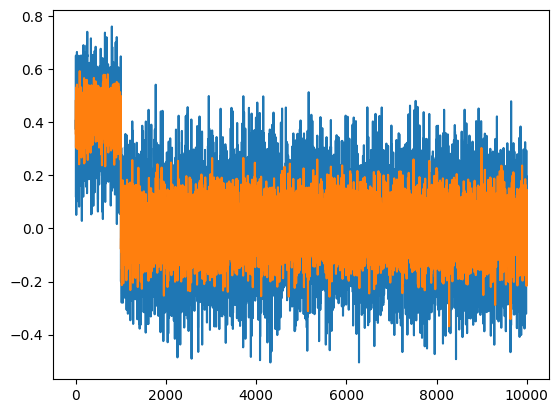

In [2]:
import matplotlib.pyplot as plt

def corr(x,y):
    sxy = torch.einsum('nd,n->d',x,y)
    sxx = torch.einsum('nd,nd->d',x,x)
    syy = torch.einsum('nd,nd->d',y.unsqueeze(1),y.unsqueeze(1))
    return sxy/((sxx*syy)**0.5)

# corr(x,y).shape
plt.plot(corr(x[Ntrain:n2],y[Ntrain:n2]))
plt.plot(corr(x,y))
plt.show()

In [3]:
import torch.nn as nn

mseLoss = nn.MSELoss()

xtr = x[:Ntrain].float().cuda()
xt = x[Ntrain:].float().cuda()
ytr = y[:Ntrain].float().cuda()
yt = y[Ntrain:].float().cuda()

w,_,_,_ = torch.linalg.lstsq(xtr,ytr)
loss = mseLoss(xt@w,yt)**0.5
print(float(loss))

0.4833517372608185


In [4]:
import sys

sys.path.append('../../LatentSimilarity')

from latsim import LatSim

print('Complete')

Complete


In [11]:
lstsqloss = []
simloss = []

for i in range(30):
    print(f'Iter {i}')

    Ntrain = 40
    Ntest = 120
    n1 = int(Ntrain/2)
    n2 = int(Ntrain+Ntest/2)
    r = 0.5
    rs = 10

    y = torch.randn(Ntrain+Ntest)
    x = 2*torch.randn(Ntrain+Ntest,10000)
    z = torch.randn(Ntrain+Ntest,10000)
    x[:,:1000] += r*y.unsqueeze(1)
    x[0:n1,1000:2000] += rs*y[0:n1].unsqueeze(1)
    x[n1:Ntrain] += rs*z[n1:Ntrain]
    x[Ntrain:n2,1000:2000] += rs*y[Ntrain:n2].unsqueeze(1)
    x[n2:] += rs*z[n2:]

    import torch.nn as nn

    mseLoss = nn.MSELoss()

    xtr = x[:Ntrain].float().cuda()
    xt = x[Ntrain:].float().cuda()
    ytr = y[:Ntrain].float().cuda()
    yt = y[Ntrain:].float().cuda()

    w,_,_,_ = torch.linalg.lstsq(xtr,ytr)
    loss = mseLoss(xt@w,yt)**0.5
    print(float(loss))
    lstsqloss.append(float(loss))

    xtr = x[:Ntrain].float().cuda().unsqueeze(1)
    xt = x[Ntrain:].float().cuda().unsqueeze(1)
    ytr = y[:Ntrain].float().cuda()
    yt = y[Ntrain:].float().cuda()
    y_t = y.float().cuda()
    x_t = x.float().cuda().unsqueeze(1)
    testIdcs = torch.arange(Ntrain,Ntrain+Ntest)

    nepochs = 200
    pperiod = 50
    verbose = False

    sim = LatSim(1, xtr, dp=0, edp=0.1, wInit=1e-4, dim=2, temp=1)
    optim = torch.optim.Adam(sim.parameters(), lr=1e-4, weight_decay=0)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.75, eps=1e-7)

    for epoch in range(nepochs):
        optim.zero_grad()
        yhat = sim(xtr, [ytr])[0][0]
        loss = mseLoss(yhat, ytr)
        loss.backward()
        optim.step()
        sched.step(loss)
        if verbose:
            if epoch % pperiod == 0 or epoch == nepochs-1:
                print(f'{epoch} {float(loss)} {sched._last_lr}')

    res = sim(x_t, [y_t], testIdcs)[0][0][testIdcs]
    loss = mseLoss(res, yt)**0.5
    print(float(loss))
    
    simloss.append(float(loss))
    
lstsqloss = np.array(lstsqloss)
simloss = np.array(simloss)

print(np.mean(lstsqloss))
print(np.mean(simloss))

Iter 0
0.5840568542480469
1.202149748802185
Iter 1
0.6143626570701599
0.9658793210983276
Iter 2
0.6113091111183167
1.035607099533081
Iter 3
0.6647010445594788
1.2980916500091553
Iter 4
0.717303991317749
0.9485212564468384
Iter 5
0.6269663572311401
1.126975417137146
Iter 6
0.6321041584014893
1.1285367012023926
Iter 7
0.6383776664733887
1.2137261629104614
Iter 8
0.7383596301078796
1.0623295307159424
Iter 9
0.5388877391815186
1.2329261302947998
Iter 10
0.656312882900238
1.1461279392242432
Iter 11
0.6762472987174988
1.2166942358016968
Iter 12
0.6680344343185425
0.9778640270233154
Iter 13
0.6682305335998535
1.2566022872924805
Iter 14
0.6905505657196045
1.0212657451629639
Iter 15
0.6982647180557251
1.5096254348754883
Iter 16
0.6599481701850891
1.1176316738128662
Iter 17
0.6792071461677551
1.0664854049682617
Iter 18
0.5663450956344604
0.9125022292137146
Iter 19
0.6157525181770325
0.9905269145965576
Iter 20
0.7677915096282959
0.9806879758834839
Iter 21
0.7062152624130249
0.9337274432182312
Ite

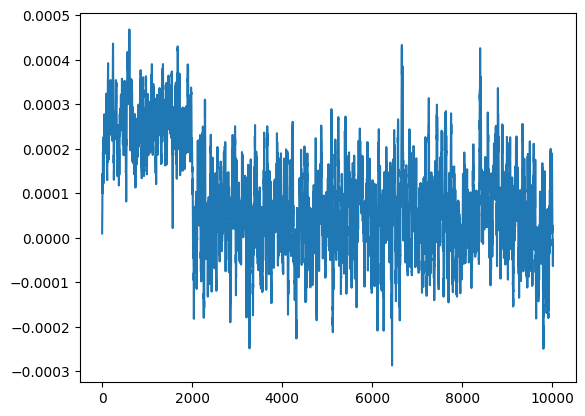

In [6]:
from scipy.signal import convolve

filt = np.ones(20)/20
wnp = w.detach().cpu().numpy()
wnp = convolve(wnp, filt)
simwnp = sim.w[0,0,:,1].detach().cpu().numpy()
simwnp = convolve(simwnp, filt)

# plt.plot(wnp)
plt.plot(simwnp)
plt.show()

In [321]:
print(sim.w.shape)

torch.Size([1, 1, 10000, 2])


In [684]:
torch.rand(10)

tensor([0.8823, 0.6347, 0.4598, 0.9600, 0.8053, 0.2300, 0.4993, 0.4138, 0.7333,
        0.4452])